In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os
'''from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter'''

'from plotly import plotly\nimport plotly.offline as offline\nimport plotly.graph_objs as go\noffline.init_notebook_mode()\nfrom collections import Counter'

1.1 Loading Data

In [2]:
import pandas
data = pandas.read_csv('preprocessed_data.csv')
data.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


1.2 Splitting data into train and cross validation (or test) : stratified sampling

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

1.3 Make Data Model Ready: encoding eassay

In [3]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [4]:
sent = decontracted(data['essay'].values[20000])
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

a person person no matter small dr seuss i teach smallest students biggest enthusiasm learning my students learn many different ways using senses multiple intelligences i use wide range techniques help students succeed students class come variety different backgrounds makes wonderful sharing experiences cultures including native americans our school caring community successful learners seen collaborative student project based learning classroom kindergarteners class love work hands materials many different opportunities practice skill mastered having social skills work cooperatively friends crucial aspect kindergarten curriculum montana perfect place learn agriculture nutrition my students love role play pretend kitchen early childhood classroom i several kids ask can try cooking real food i take idea create common core cooking lessons learn important math writing concepts cooking delicious healthy food snack time my students grounded appreciation work went making food knowledge ingred

In [5]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

a person person no matter small dr seuss i teach smallest students biggest enthusiasm learning my students learn many different ways using senses multiple intelligences i use wide range techniques help students succeed students class come variety different backgrounds makes wonderful sharing experiences cultures including native americans our school caring community successful learners seen collaborative student project based learning classroom kindergarteners class love work hands materials many different opportunities practice skill mastered having social skills work cooperatively friends crucial aspect kindergarten curriculum montana perfect place learn agriculture nutrition my students love role play pretend kitchen early childhood classroom i several kids ask can try cooking real food i take idea create common core cooking lessons learn important math writing concepts cooking delicious healthy food snack time my students grounded appreciation work went making food knowledge ingred

In [6]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [7]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
    
data['preprocessed_essays'] = preprocessed_essays

print(data.shape)
#print(project_data.head(2))
    

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [01:31<00:00, 1194.92it/s]


(109248, 10)


In [8]:
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,preprocessed_essays
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,fortunate enough use fairy tale stem kits clas...
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,imagine 8 9 years old third grade classroom se...


In [9]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,preprocessed_essays
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,fortunate enough use fairy tale stem kits clas...


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [11]:
#Vectorization of feature - essay(Text) with BOW
all_feature_names_bow=[]
print('Before')
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("***************************************************************************************************************")

vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['preprocessed_essays'].values) # fit should be donw only on train data
count = 0
for i in vectorizer.get_feature_names():
    all_feature_names_bow.append(i)
    count+=1
print('no of features in essay:', count)
print('size: ', len(all_feature_names_bow))
# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['preprocessed_essays'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['preprocessed_essays'].values)
X_test_essay_bow = vectorizer.transform(X_test['preprocessed_essays'].values)

print("After")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)

Before
(49041, 9) (49041,)
(24155, 9) (24155,)
(36052, 9) (36052,)
***************************************************************************************************************
no of features in essay: 5000
size:  5000
After
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


1.4 Make Data Model Ready: encoding numerical, categorical features

In [12]:
#Vectorizion of clean_categories (categorical feature)
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit should be done on train data only

# we use the fitted CountVectorizer to convert the text to vector
X_train_cleancate = vectorizer.transform(X_train['clean_categories'].values)
X_cv_cleancate = vectorizer.transform(X_cv['clean_categories'].values)
X_test_cleancate = vectorizer.transform(X_test['clean_categories'].values)

count = 0
for i in vectorizer.get_feature_names():
    all_feature_names_bow.append(i)
    count+=1
print('no of features in clean_categories:', count)
print('size: ', len(all_feature_names_bow))

print('feature vector is')
print(vectorizer.get_feature_names())
print("After vectorization")
print(X_train_cleancate.shape, y_train.shape)
print(X_cv_cleancate.shape, y_cv.shape)
print(X_test_cleancate.shape, y_test.shape)


no of features in clean_categories: 9
size:  5009
feature vector is
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
After vectorization
(49041, 9) (49041,)
(24155, 9) (24155,)
(36052, 9) (36052,)


In [13]:
#Vectorizion of clean_subcategories (categorical feature)
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit should be done on train data only

# we use the fitted CountVectorizer to convert the text to vector
X_train_cleansubcate = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_cleansubcate = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_cleansubcate = vectorizer.transform(X_test['clean_subcategories'].values)

count = 0
for i in vectorizer.get_feature_names():
    all_feature_names_bow.append(i)
    count+=1
print('no of features in clean_subcategories:', count)
print('size: ', len(all_feature_names_bow))

print('feature vector is')
print(vectorizer.get_feature_names())
print("After vectorization")
print(X_train_cleansubcate.shape, y_train.shape)
print(X_cv_cleansubcate.shape, y_cv.shape)
print(X_test_cleansubcate.shape, y_test.shape)


no of features in clean_subcategories: 30
size:  5039
feature vector is
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']
After vectorization
(49041, 30) (49041,)
(24155, 30) (24155,)
(36052, 30) (36052,)


In [14]:
#Vectorizion of school_state (categorical feature)
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit should be done on train data only
# we use the fitted CountVectorizer to convert the text to vector
X_train_state = vectorizer.transform(X_train['school_state'].values)
X_cv_state = vectorizer.transform(X_cv['school_state'].values)
X_test_state = vectorizer.transform(X_test['school_state'].values)

count = 0
for i in vectorizer.get_feature_names():
    all_feature_names_bow.append(i)
    count+=1
print('no of features in school_state:', count)
print('size: ', len(all_feature_names_bow))

print("After vectorizations")
print(X_train_state.shape, y_train.shape)
print(X_cv_state.shape, y_cv.shape)
print(X_test_state.shape, y_test.shape)
print(vectorizer.get_feature_names())

no of features in school_state: 51
size:  5090
After vectorizations
(49041, 51) (49041,)
(24155, 51) (24155,)
(36052, 51) (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [15]:
#Vectorizion of teacher_prefix (categorical feature)
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit should be done on train data only
# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_prefix = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_prefix = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_prefix = vectorizer.transform(X_test['teacher_prefix'].values)

count = 0
for i in vectorizer.get_feature_names():
    all_feature_names_bow.append(i)
    count+=1
print('no of features in teacher_prefix:', count)
print('size: ', len(all_feature_names_bow))

print("After vectorizations")
print(X_train_teacher_prefix.shape, y_train.shape)
print(X_cv_teacher_prefix.shape, y_cv.shape)
print(X_test_teacher_prefix.shape, y_test.shape)
print(vectorizer.get_feature_names())

no of features in teacher_prefix: 5
size:  5095
After vectorizations
(49041, 5) (49041,)
(24155, 5) (24155,)
(36052, 5) (36052,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [16]:
#Vectorizion of project_grade_category (categorical feature)
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit should be done on train data only
# we use the fitted CountVectorizer to convert the text to vector
X_train_project_grade_category = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_project_grade_category = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_project_grade_category = vectorizer.transform(X_test['project_grade_category'].values)

count = 0
for i in vectorizer.get_feature_names():
    all_feature_names_bow.append(i)
    count+=1
print('no of features in project_grade_category:', count)
print('size: ', len(all_feature_names_bow))

print("After vectorizations")
print(X_train_project_grade_category.shape, y_train.shape)
print(X_cv_project_grade_category.shape, y_cv.shape)
print(X_test_project_grade_category.shape, y_test.shape)
print(vectorizer.get_feature_names())

no of features in project_grade_category: 4
size:  5099
After vectorizations
(49041, 4) (49041,)
(24155, 4) (24155,)
(36052, 4) (36052,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [17]:
#Vectorizion of price (numerical feature)
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
#reshape is used to convert row vector to coulmn vector
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_price = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price = normalizer.transform(X_test['price'].values.reshape(-1,1))

all_feature_names_bow.append("price")
print('size: ', len(all_feature_names_bow))

print("After vectorizations")
print(X_train_price.shape, y_train.shape)
print(X_cv_price.shape, y_cv.shape)
print(X_test_price.shape, y_test.shape)

size:  5100
After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


In [18]:
#Vectorization of teacher_number_of_previously_posted_projects (numerical data)
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_previously_posted_proj = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_previously_posted_proj = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_previously_posted_proj = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

all_feature_names_bow.append("teacher_number_of_previously_posted_projects")
print('size: ', len(all_feature_names_bow))

print("After vectorizations")
print(X_train_previously_posted_proj.shape, y_train.shape)
print(X_cv_previously_posted_proj.shape, y_cv.shape)
print(X_test_previously_posted_proj.shape, y_test.shape)

size:  5101
After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


Concatinating all the features

In [19]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_bow, X_train_cleancate, X_train_cleansubcate, X_train_state, X_train_teacher_prefix,X_train_project_grade_category,X_train_price,X_train_previously_posted_proj)).tocsr().toarray()
X_cr = hstack((X_cv_essay_bow, X_cv_cleancate, X_cv_cleansubcate, X_cv_state, X_cv_teacher_prefix,X_cv_project_grade_category,X_cv_price,X_cv_previously_posted_proj)).tocsr().toarray()
X_te = hstack((X_test_essay_bow, X_test_cleancate, X_test_cleansubcate, X_test_state, X_test_teacher_prefix,X_test_project_grade_category,X_test_price,X_test_previously_posted_proj)).tocsr().toarray()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(49041, 5101) (49041,)
(24155, 5101) (24155,)
(36052, 5101) (36052,)


In [20]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

Finding best parameter which will give maximum AUC Value

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.42s/it]


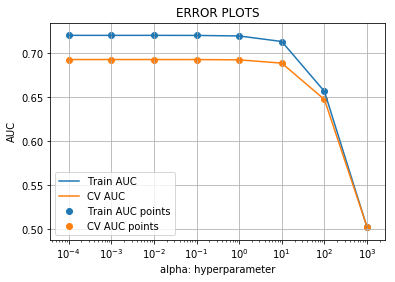

[0.6924795920384719, 0.6924793585843212, 0.6924759168031307, 0.6924425328596056, 0.6921105343770841, 0.6883782695220431, 0.6470963252902643, 0.5023464343266928]
[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]


In [27]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from sklearn.naive_bayes import MultinomialNB
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
a = [0.0001,0.001,0.01,0.1,1,10,100,1000]
for i in tqdm(a):
    #neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    #model = GaussianNB()
    #model = BernoulliNB(alpha=i, binarize=0.0, class_prior=None, fit_prior=True)
    model = MultinomialNB(alpha=i,class_prior=[0.5,0.5])
    model.fit(X_tr, y_train)

    y_train_pred = batch_predict(model, X_tr)    
    y_cv_pred = batch_predict(model, X_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

#plt.plot(a, train_auc, label='Train AUC')
#plt.plot(a, cv_auc, label='CV AUC')

plt.semilogx(a, train_auc, label='Train AUC')
plt.semilogx(a, cv_auc, label='CV AUC')



plt.scatter(a, train_auc, label='Train AUC points')
plt.scatter(a, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()
print(cv_auc)
print(a)

AUC at alpha = 0.0001,0.001 is almost same
lets try with both alpha = 0.0001, alpha = 0.001
AUC is maximum at alpha = 0.1
hence lets go with alpha=0.1

Finding Best hyper parameter using GridsearchCV: 

In [ ]:
#gridsearchcv taking so much time to execute
'''from sklearn.model_selection import GridSearchCV
#mnb_bow = MultinomialNB(class_prior=[0.5, 0.5])
model = BernoulliNB(binarize=0.0, class_prior=None, fit_prior=True)
parameters = {'alpha':[3, 15, 25, 51, 101]}
clf = GridSearchCV(model, parameters, cv= 10, scoring='roc_auc',verbose=1,return_train_score=True)
# clf.fit(x_cv_onehot_bow, y_cv)
clf.fit(X_tr, y_train)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']
bestAlpha_1=clf.best_params_['alpha']
bestScore_1=clf.best_score_
print("BEST ALPHA: ",clf.best_params_['alpha']," BEST SCORE: ",clf.best_score_) #clf.best_estimator_.alpha'''

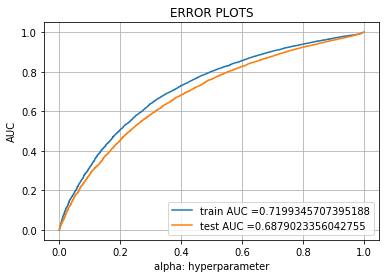

In [29]:
# first we will try with alpha = 0.0001
#Training model on using best k.
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

model = MultinomialNB(alpha=0.0001,class_prior=[0.5,0.5])
model.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(model, X_tr)    
y_test_pred = batch_predict(model, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

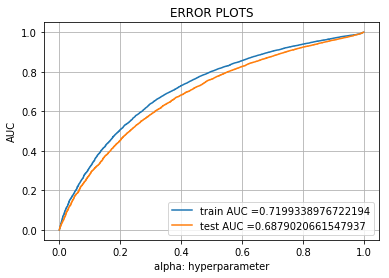

In [30]:
# Now take alpha = 0.001
#Training model on using best k.
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

model = MultinomialNB(alpha=0.001,class_prior=[0.5,0.5])
model.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(model, X_tr)    
y_test_pred = batch_predict(model, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

error plots for both the aplhas are almost same.
we will go for aplha = 0.001 due to very small difference of AUC.

In [31]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    #print(t)
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [32]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.44942563251903944 for threshold 0.526
Train confusion matrix
[[ 5051  2375]
 [14118 27497]]
Test confusion matrix
[[ 3457  2002]
 [10681 19912]]


Finding TOP 20 features
refered from https://www.kaggle.com/nikhilparmar9/naive-bayes-donorschoose-dataset/comments#620511

In [33]:
print(len(all_feature_names_bow))
totalFeatureNamesBow=len(all_feature_names_bow)
X_tr.shape

5101


(49041, 5101)

In [34]:
from sklearn.naive_bayes import MultinomialNB
nb_bow=MultinomialNB(alpha=0.001,class_prior=[0.5,0.5])
nb_bow.fit(X_tr, y_train)



MultinomialNB(alpha=0.001, class_prior=[0.5, 0.5], fit_prior=True)

In [35]:
bow_features_probs_neg = {}

for a in range (totalFeatureNamesBow):
# for a in range(101) :
    bow_features_probs_neg[a] = nb_bow.feature_log_prob_[0,a]

In [36]:
final_bow_features_neg = pd.DataFrame({'feature_prob_estimates' : list(bow_features_probs_neg.values()),
'feature_names' : list(all_feature_names_bow)})

In [37]:
result = final_bow_features_neg.sort_values(by = ['feature_prob_estimates'], ascending = False)

In [38]:
print("TOP 20 Negative features - BOW")
result.head(20)

TOP 20 Negative features - BOW


,feature_prob_estimates,feature_names
4114,-3.150351,students
3673,-4.259519,school
2377,-4.551729,learning
690,-4.725637,classroom
2324,-4.918292,learn
2979,-4.928059,not
1940,-4.965950,help
5099,-5.081786,price
2880,-5.125272,nannan
2668,-5.168822,many


In [39]:
result2 = final_bow_features_neg.sort_values(by = ['feature_prob_estimates'], ascending = True)
print("TOP 20 Negative features - BOW")
result2.head(20)

TOP 20 Negative features - BOW


,feature_prob_estimates,feature_names
5090,-13.993530,dr
5089,-12.607985,wy
5067,-11.914963,nd
4882,-11.914963,wobble cushions
5085,-11.914963,vt
1850,-11.691844,graphing
660,-11.596543,chromebooks allow
5016,-11.509539,economics
5047,-11.429503,de
4726,-11.286412,using ipads


TASK 2 : with Set 2: categorical, numerical features + preprocessed_eassay (TFIDF)

In [40]:
#Preprocessing using tfidf, code copied from sample solution
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer2 = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer2.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer2.transform(X_train['preprocessed_essays'].values)
X_cv_essay_tfidf = vectorizer2.transform(X_cv['preprocessed_essays'].values)
X_test_essay_tfidf = vectorizer2.transform(X_test['preprocessed_essays'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

After vectorizations
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


Concatinate all the features

In [41]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_TFIDF = hstack((X_train_essay_tfidf, X_train_cleancate, X_train_cleansubcate, X_train_state, X_train_teacher_prefix,X_train_project_grade_category,X_train_price,X_train_previously_posted_proj)).tocsr().toarray()
X_cr_TFIDF = hstack((X_cv_essay_tfidf, X_cv_cleancate, X_cv_cleansubcate, X_cv_state, X_cv_teacher_prefix,X_cv_project_grade_category,X_cv_price,X_cv_previously_posted_proj)).tocsr().toarray()
X_te_TFIDF = hstack((X_test_essay_tfidf, X_test_cleancate, X_test_cleansubcate, X_test_state, X_test_teacher_prefix,X_test_project_grade_category,X_test_price,X_test_previously_posted_proj)).tocsr().toarray()

print("Final Data matrix")
print(X_tr_TFIDF.shape, y_train.shape)
print(X_cr_TFIDF.shape, y_cv.shape)
print(X_te_TFIDF.shape, y_test.shape)

Final Data matrix
(49041, 5101) (49041,)
(24155, 5101) (24155,)
(36052, 5101) (36052,)


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.49s/it]


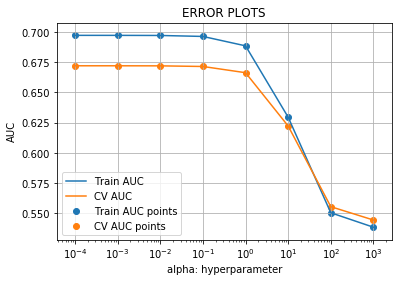

[0.6721141525162102, 0.6721093633710651, 0.6720576966324946, 0.6715299301694613, 0.6663802784550393, 0.6222417025258912, 0.5554526044985467, 0.5444061944270733]
[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]


In [43]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
a = [0.0001,0.001,0.01,0.1,1,10,100,1000]
for i in tqdm(a):
    #neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    #model = GaussianNB()
    #model = BernoulliNB(alpha=i, binarize=0.0, class_prior=None, fit_prior=True)
    model = MultinomialNB(alpha=i,class_prior=[0.5,0.5])
    model.fit(X_tr_TFIDF, y_train)

    y_train_pred = batch_predict(model, X_tr_TFIDF)    
    y_cv_pred = batch_predict(model, X_cr_TFIDF)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.semilogx(a, train_auc, label='Train AUC')
plt.semilogx(a, cv_auc, label='CV AUC')

plt.scatter(a, train_auc, label='Train AUC points')
plt.scatter(a, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()
print(cv_auc)
print(a)

In [ ]:
AUC is maximum at alpha=0.0001

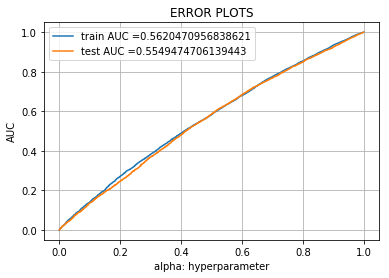

In [44]:
#Training model on using best k.
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

model = MultinomialNB(alpha=0.0001,class_prior=[0.5,0.5])
model.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(model, X_tr_TFIDF)    
y_test_pred = batch_predict(model, X_te_TFIDF)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [45]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "HyperParameter", "AUC"]

x.add_row(["BOW", "Brute", 0.001, 0.6879])
x.add_row(["TFIDF", "Brute", 0.0001, 0.55494])

x.align["Vectorizer"] = "l"
print(x)

+------------+-------+----------------+---------+
| Vectorizer | Model | HyperParameter |   AUC   |
+------------+-------+----------------+---------+
| BOW        | Brute |     0.001      |  0.6879 |
| TFIDF      | Brute |     0.0001     | 0.55494 |
+------------+-------+----------------+---------+
